# Predict next transaction day

Inspired by [this talk](https://www.youtube.com/watch?v=uU1u6JQCg5U) on hazard models and the poor performance of using Regression to predict next purchase day in the Customer Lifetime Value modelling notebook, an attempt is made here to employ a [Survival Model](https://www.opendoor.com/w/blog/liquidity-modeling-real-estate-survival-analysis) in order to predict the next transaction date for customers in the E-commerce dataset. The model doesn't perform particularly well and a few reasons are discussed for why this might be the case (mainly the lack of at least a whole year of data).

By Wong Tran

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from lifetimes.fitters.modified_beta_geo_fitter import ModifiedBetaGeoFitter
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data

Import the data

In [2]:
transaction_df = pd.read_excel("data/Online_Retail.xlsx")
transaction_df['InvoiceDate'] = pd.to_datetime(transaction_df['InvoiceDate'])
transaction_df['Revenue'] = transaction_df['UnitPrice'] * transaction_df['Quantity']

# Get rid of the first month
transaction_df = transaction_df[transaction_df.InvoiceDate>=pd.datetime(2011,1,1)]

# Exclude return transactions?
transaction_df = transaction_df[transaction_df.Quantity>-1]

# UK only?
#transaction_df = transaction_df[transaction_df.Country=="United Kingdom"]

<br>
<br>

### Notes

- The Calibration (training) period is the first half of the year whilst the Holdout (test) period is the second half of the year
- I use customers who purchased at least three times in the calibration period and once in the holdout for the survival analysis
- Train on Calibration period and predict the customer's next purchase in the Holdout period
- I use "purchase" and "transaction" interchangeably in this notebook but they mean the exact same thing

<br>
<br>

### To do

- Replace the data prepraration steps below with a script and import

In [3]:
# Split the dataset in two halfway, 1st half:Calibration, 2nd half:Holdout
t_halfway = (transaction_df.InvoiceDate.max() - transaction_df.InvoiceDate.min())/2
t_halfway = transaction_df.InvoiceDate.min() + t_halfway

transaction_df_calib = transaction_df[transaction_df.InvoiceDate<=t_halfway]
transaction_df_holdout = transaction_df[transaction_df.InvoiceDate>t_halfway]

# Only keep the first transaction on each day for each customer
transaction_df_calib['InvoiceDay'] = transaction_df_calib['InvoiceDate'].dt.date
transaction_df_calib.drop_duplicates(subset=['CustomerID', 'InvoiceDay'], keep='first', inplace=True)
transaction_df_holdout['InvoiceDay'] = transaction_df_holdout['InvoiceDate'].dt.date
transaction_df_holdout.drop_duplicates(subset=['CustomerID', 'InvoiceDay'], keep='first', inplace=True)

# Customers who made at least three transactions in the calibration period
num_purchases_calib = transaction_df_calib.groupby(['CustomerID'])['InvoiceDay'].count().reset_index()
calib_3_purchases = num_purchases_calib[num_purchases_calib.InvoiceDay>2]
calib_3_purchases.columns = ['CustomerID', 'NumCalibPurchases']
del num_purchases_calib

# Customers who made one transaction in the holdout period
num_purchases_holdout = transaction_df_holdout.groupby(['CustomerID'])['InvoiceDay'].count().reset_index()
holdout_1_purchase = num_purchases_holdout[num_purchases_holdout.InvoiceDay>0]
holdout_1_purchase.columns = ['CustomerID', 'NumHoldoutPurchases']
del num_purchases_holdout

# Customers who did both. We use these customers to train and test the Survival model
survival_customers = calib_3_purchases.merge(holdout_1_purchase, how='inner', on='CustomerID')
del calib_3_purchases, holdout_1_purchase

# Get the transaction history for Survival analysis customers
survival_transaction_history = transaction_df_calib[transaction_df_calib.CustomerID.isin(survival_customers.CustomerID)]
survival_transaction_history.sort_values(['CustomerID', 'InvoiceDate'], inplace=True)

# Get the first purchase date for the survival customers
survival_purchase_dates = survival_transaction_history.groupby('CustomerID')['InvoiceDate'].min().reset_index()
survival_purchase_dates.columns = ['CustomerID', 'FirstPurchaseDate']

# Get the second purchase date for the survival customers
second_purchase = survival_transaction_history[['CustomerID', 'InvoiceDate']].copy()
second_purchase['NextPurchaseDate'] = survival_transaction_history.groupby(['CustomerID'])['InvoiceDate'].shift(-1)
survival_purchase_dates['SecondPurchaseDate'] = second_purchase.groupby('CustomerID')['NextPurchaseDate'].min().reset_index()['NextPurchaseDate']
del second_purchase

# Get the third purchase date for the survival customers
third_purchase = survival_transaction_history[['CustomerID', 'InvoiceDate']].copy()
third_purchase['NextPurchaseDate'] = survival_transaction_history.groupby(['CustomerID'])['InvoiceDate'].shift(-2)
survival_purchase_dates['ThirdPurchaseDate'] = third_purchase.groupby('CustomerID')['NextPurchaseDate'].min().reset_index()['NextPurchaseDate']
del third_purchase

# Dates only, (no time of day)
survival_purchase_dates.FirstPurchaseDate = survival_purchase_dates.FirstPurchaseDate.dt.date
survival_purchase_dates.SecondPurchaseDate = survival_purchase_dates.SecondPurchaseDate.dt.date
survival_purchase_dates.ThirdPurchaseDate = survival_purchase_dates.ThirdPurchaseDate.dt.date

# Days between purchases #2 and #1 & #3 and #2 for the survival customers
survival_purchase_dates['DaysBetween2and1'] = (survival_purchase_dates['SecondPurchaseDate'] - survival_purchase_dates['FirstPurchaseDate']).dt.days
survival_purchase_dates['DaysBetween3and2'] = (survival_purchase_dates['ThirdPurchaseDate'] - survival_purchase_dates['SecondPurchaseDate']).dt.days

# Use days between transaction to create Discrete Time Model data. We train on the days between 2nd and 3rd purchases
train_dict = {'CustomerID':[], 'DaysWithoutPurchase':[], 'PurchasedNextDay':[], 
              'PurchaseOfTheYear':[]
             }

# Days till 2nd transaction
for row in survival_purchase_dates.iterrows():
    customer = row[1]
    for day in range(0, customer.DaysBetween2and1):
        train_dict['CustomerID'].append(customer.CustomerID)
        train_dict['DaysWithoutPurchase'].append(day)
        train_dict['PurchaseOfTheYear'].append(2)
        if day == customer.DaysBetween2and1 - 1:  # 1 for Customer purchasing on the next day
            train_dict['PurchasedNextDay'].append(1)
        else:
            train_dict['PurchasedNextDay'].append(0)

# Days till 3rd transaction
for row in survival_purchase_dates.iterrows():
    customer = row[1]
    for day in range(0, customer.DaysBetween3and2):
        train_dict['CustomerID'].append(customer.CustomerID)
        train_dict['DaysWithoutPurchase'].append(day)
        train_dict['PurchaseOfTheYear'].append(3)
        if day == customer.DaysBetween3and2 - 1:  # 1 for Customer purchasing on the next day
            train_dict['PurchasedNextDay'].append(1)
        else:
            train_dict['PurchasedNextDay'].append(0)

train_df = pd.DataFrame(train_dict)
del train_dict

################################################## Get Train-Test Data #######################################################

# For evaluating training error

train_test_dict = {'CustomerID':[], 'DaysWithoutPurchase':[], 'PurchasedNextDay':[]}

for row in survival_purchase_dates.iterrows():
    customer = row[1]
    for day in range(0, 180):
        train_test_dict['CustomerID'].append(customer.CustomerID)
        train_test_dict['DaysWithoutPurchase'].append(day)
        if day == customer.DaysBetween3and2 - 1:  # Customer purchased next day
            train_test_dict['PurchasedNextDay'].append(1)
        else:
            train_test_dict['PurchasedNextDay'].append(0)
    
train_test_df = pd.DataFrame(train_test_dict)
train_test_df['PurchaseOfTheYear'] = 3
del train_test_dict

#################################################### Get Test Data #######################################################

# For evaluating test error

# Get the holdout transactions for Survival analysis customers
survival_transaction_holdout = transaction_df_holdout[transaction_df_holdout.CustomerID.isin(survival_customers.CustomerID)]
survival_transaction_holdout.sort_values(['CustomerID', 'InvoiceDate'], inplace=True)

# Get the last calibration purchase date and first holdout purchase date
survival_purchase_dates['CalibLastPurchaseDate'] = survival_transaction_history.groupby('CustomerID')['InvoiceDate'].max().reset_index()['InvoiceDate']
survival_purchase_dates['HoldoutFirstPurchaseDate'] = survival_transaction_holdout.groupby('CustomerID')['InvoiceDate'].min().reset_index()['InvoiceDate']

# Dates only, (no time of day)
survival_purchase_dates.CalibLastPurchaseDate = survival_purchase_dates.CalibLastPurchaseDate.dt.date
survival_purchase_dates.HoldoutFirstPurchaseDate = survival_purchase_dates.HoldoutFirstPurchaseDate.dt.date

# Days between purchases of final calibration transaction and first holdout transaction
survival_purchase_dates['DaysBetweenHoldoutFirstCalibLast'] = (survival_purchase_dates['HoldoutFirstPurchaseDate'] - survival_purchase_dates['CalibLastPurchaseDate']).dt.days

# Which purchase of the year is it?
survival_purchase_dates['HoldoutPurchaseOfTheYear'] = survival_transaction_history.groupby('CustomerID')['InvoiceNo'].count().reset_index()['InvoiceNo']+1

test_dict = {'CustomerID':[], 'DaysWithoutPurchase':[], 'PurchasedNextDay':[], 
             'PurchaseOfTheYear':[]
            }

for row in survival_purchase_dates.iterrows():
    customer = row[1]
    for day in range(0, 180):
        test_dict['CustomerID'].append(customer.CustomerID)
        test_dict['DaysWithoutPurchase'].append(day)
        test_dict['PurchaseOfTheYear'].append(customer.HoldoutPurchaseOfTheYear)
        if day == customer.DaysBetweenHoldoutFirstCalibLast - 1:  # Customer purchased next day
            test_dict['PurchasedNextDay'].append(1)
        else:
            test_dict['PurchasedNextDay'].append(0)


test_df = pd.DataFrame(test_dict)
del test_dict

#################################################### Build features #######################################################

# Get aggregations features using transactions made during the calibration period
previous_transactions = survival_transaction_history[['CustomerID', 'InvoiceDay']].copy()
previous_transactions['PreviousTransactionDate'] = survival_transaction_history.groupby(['CustomerID'])['InvoiceDay'].shift(1)
previous_transactions['DaysBetweenTransactions'] = (previous_transactions['InvoiceDay'] - previous_transactions['PreviousTransactionDate']).dt.days
previous_transactions_agg = previous_transactions.groupby('CustomerID')['DaysBetweenTransactions'].agg(['mean', 'std', 'min', 'max']).reset_index()
previous_transactions_agg.columns = ['CustomerID', 'MeanDaysBetweenPurchase', 'StDevDaysBetweenPurchase', 'MinDaysBetweenPurchase', 'MaxDaysBetweenPurchase']

train_df = train_df.merge(previous_transactions_agg, how='left', on='CustomerID')
train_test_df = train_test_df.merge(previous_transactions_agg, how='left', on='CustomerID')
test_df = test_df.merge(previous_transactions_agg, how='left', on='CustomerID')

del previous_transactions, previous_transactions_agg

# Get RFM features
rfm_feats = summary_data_from_transaction_data(transactions=transaction_df,
                                               customer_id_col='CustomerID',
                                               datetime_col='InvoiceDate',
                                               monetary_value_col='Revenue',
                                               freq='D',
                                               observation_period_end=t_halfway,
                                              ).reset_index()

# Get BG/NBD and GG features

# Create BG/NBD model
bgf = ModifiedBetaGeoFitter(
#    penalizer_coef=1
)

# Fit BG/NBD model to customers
bgf.fit(rfm_feats['frequency'],
        rfm_feats['recency'],
        rfm_feats['T']
       )

# Get returning customers to fit GG model
returning_customers_summary_df = rfm_feats[
    (rfm_feats.frequency>0) & \
    (rfm_feats.monetary_value>0)
]

# Create GG model
ggf = GammaGammaFitter(
#    penalizer_coef=0.1
)

# Fit GG model to customers
ggf.fit(returning_customers_summary_df['frequency'],
        returning_customers_summary_df['monetary_value'])

# Get expected profit to model predicted transaction value
expected_profit = ggf.conditional_expected_average_profit(
        rfm_feats['frequency'],
        rfm_feats['monetary_value']
)
rfm_feats['expected_profit'] = expected_profit

# Predict the number of transactions in the next 180 days (the period used for PMF and E[X] during testing)
rfm_feats['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t=180, 
                                                                                           frequency=rfm_feats['frequency'],
                                                                                           recency=rfm_feats['recency'],
                                                                                           T=rfm_feats['T'],
                                                                                          )

# Round number of predicted transactions to integers
rfm_feats['predicted_purchases'] = rfm_feats.predicted_purchases.round()

# Combine number of transactions with expected profit to get predicted revenue
rfm_feats['predicted_revenue'] = rfm_feats.expected_profit * rfm_feats.predicted_purchases

rfm_feats.drop(columns=['expected_profit'], inplace=True)

# Left merge to get features only for customers used in the Survival analysis
train_df = train_df.merge(rfm_feats, how='left', on='CustomerID')
train_test_df = train_test_df.merge(rfm_feats, how='left', on='CustomerID')
test_df = test_df.merge(rfm_feats, how='left', on='CustomerID')

del rfm_feats

##################################################### Build model  #######################################################

X_train = train_df.drop(columns=['CustomerID', 'PurchasedNextDay'])
y_train = train_df[['PurchasedNextDay']]

X_train_test = train_test_df.drop(columns=['CustomerID', 'PurchasedNextDay'])
y_train_test = train_test_df[['PurchasedNextDay']]

X_test = test_df.drop(columns=['CustomerID', 'PurchasedNextDay'])
y_test = test_df[['PurchasedNextDay']]

lr = LogisticRegression(solver='lbfgs', max_iter=10000, n_jobs=4, C=1)
lr.fit(X_train, y_train.values.ravel())

# LR model produces Hazard probabilities
y_pred_train = lr.predict_proba(X_train_test)
y_pred_test = lr.predict_proba(X_test)

y_pred_train_df = train_test_df[['CustomerID', 'DaysWithoutPurchase']].copy()
y_pred_train_df['P(purchase_tomorrow|survived_till_today)'] = y_pred_train[:,1]
y_pred_test_df = test_df[['CustomerID', 'DaysWithoutPurchase']].copy()
y_pred_test_df['P(purchase_tomorrow|survived_till_today)'] = y_pred_test[:,1]

# Compute probabiity of survival using hazard
def compute_survival(hazard_rates):
    survival = []
    for idx, h in enumerate(hazard_rates):
        survival.append(np.product(1-hazard_rates[:idx+1]))
    return np.array(survival)

customer_survival = np.array([])
for i in y_pred_train_df.CustomerID.unique():
    customer_hazard_rates = y_pred_train_df[y_pred_train_df.CustomerID==i]['P(purchase_tomorrow|survived_till_today)'].values
    customer_survival = np.concatenate((customer_survival, compute_survival(customer_hazard_rates)))
y_pred_train_df['Survival'] = customer_survival

customer_survival = np.array([])
for i in y_pred_test_df.CustomerID.unique():
    customer_hazard_rates = y_pred_test_df[y_pred_test_df.CustomerID==i]['P(purchase_tomorrow|survived_till_today)'].values
    customer_survival = np.concatenate((customer_survival, compute_survival(customer_hazard_rates)))
y_pred_test_df['Survival'] = customer_survival

del customer_survival, customer_hazard_rates

# Convert Hazard probabilities to a PMF over the future period
def compute_PMF(hazard_rates):
    pmf = []
    for idx, h in enumerate(hazard_rates):
        if idx == 0:
            pmf.append(h)
        else:
            pmf.append((np.product(1-hazard_rates[:idx])*h))
    return np.array(pmf)

customer_pmfs = np.array([])
for i in y_pred_train_df.CustomerID.unique():
    customer_hazard_rates = y_pred_train_df[y_pred_train_df.CustomerID==i]['P(purchase_tomorrow|survived_till_today)'].values
    customer_pmfs = np.concatenate((customer_pmfs, compute_PMF(customer_hazard_rates)))
y_pred_train_df['PMF'] = customer_pmfs

customer_pmfs = np.array([])
for i in y_pred_test_df.CustomerID.unique():
    customer_hazard_rates = y_pred_test_df[y_pred_test_df.CustomerID==i]['P(purchase_tomorrow|survived_till_today)'].values
    customer_pmfs = np.concatenate((customer_pmfs, compute_PMF(customer_hazard_rates)))
y_pred_test_df['PMF'] = customer_pmfs
del customer_pmfs, customer_hazard_rates

# Expected days till purchase using E[X] = sum(x&P(x))
y_pred_train_df['day*PMF'] = y_pred_train_df.DaysWithoutPurchase * y_pred_train_df.PMF
y_pred_train_expected = y_pred_train_df.groupby('CustomerID')['day*PMF'].sum().reset_index()
y_pred_train_expected.columns = ['CustomerID', 'PredDaysTillPurchase']

y_pred_test_df['day*PMF'] = y_pred_test_df.DaysWithoutPurchase * y_pred_test_df.PMF
y_pred_test_expected = y_pred_test_df.groupby('CustomerID')['day*PMF'].sum().reset_index()
y_pred_test_expected.columns = ['CustomerID', 'PredDaysTillPurchase']

<br>
<br>

### Training data

Features generated from the transaction history:

- **DaysWithoutPurchase** - The discrete time steps used by the Logistic Regression to perform Survival modelling
- **PurchaseOfTheYear** - What # purchase of the year is the model trying to predict? (n.b. a cyclical feature would probably be better)
- **Mean/StDev/Min/MaxDaysBetweenPurchase** - Aggregation statistics calculated using transactions made during the calibration period
- **recency/frequency/T/monetary_value** - RFM summary statistics (see CLV notebook)
- **predicted_purchases/predicted_revenue** - Number/Value of transactions each customer is predicted to make (using BG/NBD and GG model) in the next 180 days of the calibration period.

The target variable:

**PurchasedNextDay** - Whether the customer made a transaction in the next time step

All covariates apart from the time steps are non-temporal attributes of each customer. Temporal features can be added by creating binary categorical features that are active over a particular set of time steps. (e.g. promotional periods, holidays periods, etc)

An example of what a set of training data looks like for a particular customer is shown below. This customer made a purchase 36 days after their second purchase of the year.

In [4]:
train_df[train_df.CustomerID==18283.0].tail(10)

,CustomerID,DaysWithoutPurchase,PurchasedNextDay,PurchaseOfTheYear,MeanDaysBetweenPurchase,StDevDaysBetweenPurchase,MinDaysBetweenPurchase,MaxDaysBetweenPurchase,frequency,recency,T,monetary_value,predicted_purchases,predicted_revenue
47157,18283.0,26,0,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886
47158,18283.0,27,0,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886
47159,18283.0,28,0,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886
47160,18283.0,29,0,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886
47161,18283.0,30,0,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886
47162,18283.0,31,0,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886
47163,18283.0,32,0,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886
47164,18283.0,33,0,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886
47165,18283.0,34,0,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886
47166,18283.0,35,1,3,31.8,13.608821,17.0,52.0,5.0,159.0,167.0,106.064,5.0,758.759886


### Predictions and Discussion of Results

In [5]:
print("Train MSE for days between transactions: {:.3f}".format(np.sqrt(mean_squared_error(y_pred_train_expected.PredDaysTillPurchase, survival_purchase_dates.DaysBetween3and2))))
print("Test MSE for days between transactions: {:.3f}".format(np.sqrt(mean_squared_error(y_pred_train_expected.PredDaysTillPurchase, survival_purchase_dates.DaysBetweenHoldoutFirstCalibLast))))

Train MSE for days between transactions: 19.353
Test MSE for days between transactions: 53.467


The Survivor model has overfit to the training set! Let's see where the majority of the incorrect predictions are

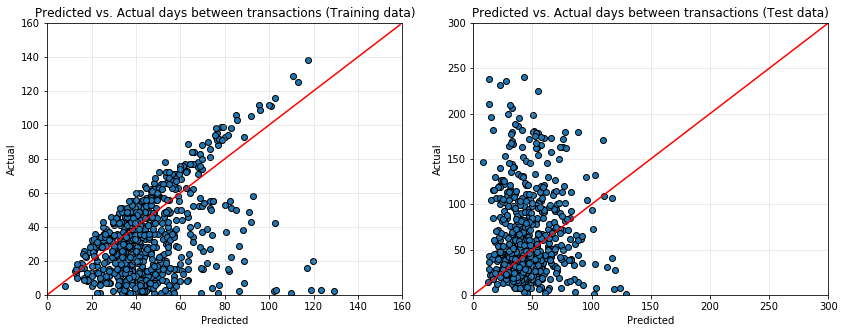

In [6]:
plt.figure(figsize=(14,5))
ax1 = plt.subplot(121)
ax1.scatter(y_pred_test_expected.PredDaysTillPurchase, survival_purchase_dates.DaysBetween3and2, edgecolor='k')
ax1.set_ylabel("Actual")
ax1.set_xlabel("Predicted")
ax1.set_title("Predicted vs. Actual days between transactions (Training data)")
ax1.set_xlim(0,160)
ax1.set_ylim(0,160)
ax1.plot(list(range(0,160)), list(range(0,160)), c='r')
ax1.grid(alpha=0.3)

ax2  = plt.subplot(122)
ax2.scatter(y_pred_test_expected.PredDaysTillPurchase, survival_purchase_dates.DaysBetweenHoldoutFirstCalibLast, edgecolor='k')
ax2.set_ylabel("Actual")
ax2.set_xlabel("Predicted")
ax2.set_title("Predicted vs. Actual days between transactions (Test data)")
ax2.set_xlim(0,300)
ax2.set_ylim(0,300)
ax2.plot(list(range(0,300)), list(range(0,300)), c='r')
ax2.grid(alpha=0.3)

- In the training data, the model is predicting transactions made approximately in the next 50 days moderately well although there are significant overestimates for >60 day predictions for some reason
- In the test data, some of the 50 day predictions are big underestimates for quite a few customers. 
- These customers, for whatever reason, purchased quite frequently in the beginning of the year but took a hiatus in purchasing until the end of the year. 

Let's have a look at the non-temporal attributes for some of these customers

In [7]:
hiatus_customers = survival_purchase_dates[survival_purchase_dates.DaysBetweenHoldoutFirstCalibLast>180].CustomerID
train_df[train_df.CustomerID.isin(hiatus_customers)].groupby('CustomerID').mean().drop(columns=['DaysWithoutPurchase', 'PurchaseOfTheYear', 'PurchasedNextDay'])

,MeanDaysBetweenPurchase,StDevDaysBetweenPurchase,MinDaysBetweenPurchase,MaxDaysBetweenPurchase,frequency,recency,T,monetary_value,predicted_purchases,predicted_revenue
CustomerID,,,,,,,,,,
12352.0,11.333333,5.686241,5.0,16.0,3.0,34.0,126.0,421.770000,4.0,1687.119522
12539.0,35.500000,26.162951,17.0,54.0,2.0,71.0,163.0,1400.920000,2.0,2219.803539
12728.0,37.500000,14.849242,27.0,48.0,2.0,75.0,162.0,182.385000,2.0,507.100939
13118.0,40.000000,7.071068,35.0,45.0,2.0,80.0,118.0,304.385000,3.0,1017.865666
13126.0,42.500000,30.405592,21.0,64.0,2.0,85.0,168.0,265.055000,2.0,623.297128
14299.0,9.500000,3.535534,7.0,12.0,2.0,19.0,167.0,257.400000,2.0,612.537701
14336.0,39.000000,25.455844,21.0,57.0,2.0,78.0,106.0,289.985000,3.0,987.505950
14504.0,17.500000,2.121320,16.0,19.0,2.0,35.0,108.0,197.740000,3.0,793.024563
14662.0,41.000000,0.000000,41.0,41.0,2.0,82.0,146.0,211.905000,2.0,548.592550


In [8]:
survival_purchase_dates[survival_purchase_dates.CustomerID.isin(hiatus_customers)]

,CustomerID,FirstPurchaseDate,SecondPurchaseDate,ThirdPurchaseDate,DaysBetween2and1,DaysBetween3and2,CalibLastPurchaseDate,HoldoutFirstPurchaseDate,DaysBetweenHoldoutFirstCalibLast,HoldoutPurchaseOfTheYear
1,12352.0,2011-02-16,2011-03-01,2011-03-17,13,16,2011-03-22,2011-09-20,182,5
29,12539.0,2011-01-10,2011-01-27,2011-03-22,17,54,2011-03-22,2011-11-17,240,4
58,12728.0,2011-01-11,2011-02-28,2011-03-27,48,27,2011-03-27,2011-09-29,186,4
113,13118.0,2011-02-24,2011-03-31,2011-05-15,35,45,2011-05-15,2011-11-20,189,4
114,13126.0,2011-01-05,2011-03-10,2011-03-31,64,21,2011-03-31,2011-09-28,181,4
245,14299.0,2011-01-06,2011-01-13,2011-01-25,7,12,2011-01-25,2011-08-24,211,4
249,14336.0,2011-03-08,2011-05-04,2011-05-25,57,21,2011-05-25,2011-11-23,182,4
263,14504.0,2011-03-06,2011-03-25,2011-04-10,19,16,2011-04-10,2011-10-23,196,4
280,14662.0,2011-01-27,2011-03-09,2011-04-19,41,41,2011-04-19,2011-11-11,206,4
297,14744.0,2011-01-24,2011-01-31,2011-02-15,7,15,2011-02-15,2011-10-11,238,4


These customers have mean days between transactions of less than 50 days and purchased 3/4 times in the first half of the year, but ended up making a transaction really late into the second half of the year. It makes sense why the model would think that they should purchase sooner than they actually did.

It looks like this is a seasonal trend which could be accounted for if a whole year of data was available to be used to train the model. That way a "time-of-year" feature could be incorporated which would hopefully account for the hiatuses that some customers would take during the middle of the year before Q4. 

Seasonal/temporal effects will definitely affect the transaction dates of the customers and this is the disadvantage of training a model like this on less than a year of data. 

### Compare the Hazard and Survival functions for a frequent vs. infrequent buyer

The Logistic Regression outputs a prediction for Hazard at each time step, which is the conditional probability that a customer makes a transaction in the next day given that they didn't up to that point. The Survival function is the probability of not making a transaction up to a given day (or making a transaction after that day). [See these notes](https://data.princeton.edu/wws509/notes/c7s6) for a formal definition of Hazard and Survival.

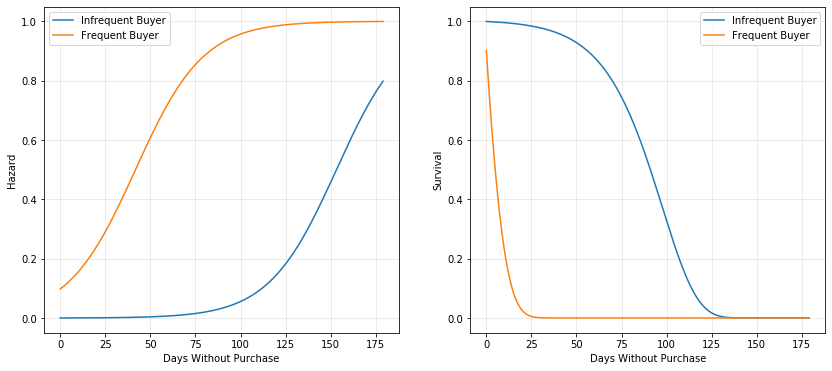

In [9]:
plt.figure(figsize=(14,6))
day = list(range(0,180))

ax1 = plt.subplot(121)
ax1.plot(day, y_pred_train_df[y_pred_train_df.CustomerID==18092]['P(purchase_tomorrow|survived_till_today)'], label='Infrequent Buyer')
ax1.plot(day, y_pred_train_df[y_pred_train_df.CustomerID==12457]['P(purchase_tomorrow|survived_till_today)'], label='Frequent Buyer')
ax1.set_ylabel("Hazard")
ax1.set_xlabel("Days Without Purchase")
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = plt.subplot(122)
ax2.plot(day, y_pred_train_df[y_pred_train_df.CustomerID==18092].Survival, label='Infrequent Buyer')
ax2.plot(day, y_pred_train_df[y_pred_train_df.CustomerID==12457].Survival, label='Frequent Buyer')
ax2.set_ylabel("Survival")
ax2.set_xlabel("Days Without Purchase")
ax2.legend();
ax2.grid(alpha=0.3)


According to the model:

- The frequent buyer has hazards over 0.15 for the entire 180 day period and is almost certain to make a transaction (if they already didn't) after 125 days
- The infrequent buyer has hazards of approximately 0 in the first 50 days and only starts increasing after that. It is almost certain that they will not make a transaction in the first 50 days  
- The frequent buyer is very unlikely to "survive" past 25 days whereas the infrequent buyer is very unlikely to "survive" past 125 days

A more intuitive plot is the PMF of making a transaction over the next 180 day period which is explored next.

### Distribution of transaction days for a frequent buyer vs. infrequent buyer

The PMF over the future transaction days is calculated using conditional probability and the fact that the probability of purchasing on a specific day is the probability of "surviving" to that day and purchasing the next day.

$$\text{Pr(Purchase next day, Survived till today)} = \text{Pr(Purchase next day|Survived till today)} \times \text{Pr(Suvived till today)}$$

The first term on the RHS is just the Hazard and the second term is the Survival function. 

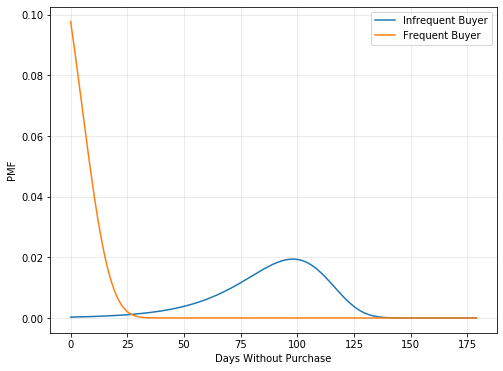

In [10]:
plt.figure(figsize=(8,6))
day = list(range(0,180))

ax1 = plt.subplot(111)
ax1.plot(day, y_pred_train_df[y_pred_train_df.CustomerID==18092]['PMF'], label='Infrequent Buyer')
ax1.plot(day, y_pred_train_df[y_pred_train_df.CustomerID==12457]['PMF'], label='Frequent Buyer')
ax1.set_ylabel("PMF")
ax1.set_xlabel("Days Without Purchase")
ax1.legend()
ax1.grid(alpha=0.3)

According to the model

- A line plot is used but time steps are actually discrete
- The frequent buyer is likely to make a transaction within the first 25 days and very unlikely to wait much longer than that to make their next transaction
- The infrequent buyer distribution is much wider, with the likeliest transaction day to be approximately 100 days, 
- It is uncertain when exactly over the next 180 days the infrequent buyer will make a transaction

Let's look at the attributes of these two customers

In [13]:
train_df[train_df.CustomerID.isin(['12457', '18092'])].groupby('CustomerID').mean().drop(columns=['DaysWithoutPurchase', 'PurchaseOfTheYear', 'PurchasedNextDay'])

,MeanDaysBetweenPurchase,StDevDaysBetweenPurchase,MinDaysBetweenPurchase,MaxDaysBetweenPurchase,frequency,recency,T,monetary_value,predicted_purchases,predicted_revenue
CustomerID,,,,,,,,,,
12457.0,3.0,2.828427,1.0,5.0,2.0,6.0,69.0,199.0,4.0,1060.908051
18092.0,73.0,42.426407,43.0,103.0,2.0,146.0,160.0,779.1,2.0,1345.809168


The PMF, Hazard and Survival functions seem to be intuitive for the frequent and infrequent customers based on their features, for example

- mean days between purchases is much higher for the infrequent buyer, 
- max days between purchases is much higher for the infrequent buyer,
- recency is much higher for the infrequent buyer (a customer who bought recently is probably not going to purchase again very soon)
- Perhaps the fact that the monetary_value is high for the infrequent buyer suggests that they make larger transactions infrequently. You would need to check the weights of the model to see if the model is indeed interpreting the monetary_value feature in this way


<br>
<br>

### Ignore this

Tune GG and BG/NBD model

In [ ]:
# Round number of predicted transactions to integers
rfm_feats.predicted_purchases = rfm_feats.predicted_purchases.round()

# How many transactions did customers actually make during holdout period?
observed_transactions = transaction_df[transaction_df.InvoiceDate>t_halfway].groupby(["CustomerID", transaction_df["InvoiceDate"].dt.to_period("D")])['InvoiceNo'].count().reset_index()
observed_transactions = observed_transactions['CustomerID'].value_counts().reset_index()
observed_transactions.columns = ['CustomerID', 'observed_purchases']
rfm_feats = rfm_feats.merge(observed_transactions, how='left', on='CustomerID')
rfm_feats.fillna(0, inplace=True)
del observed_transactions


# Combine number of transactions with expected profit to get predicted revenue
rfm_feats['predicted_revenue'] = rfm_feats.expected_profit * rfm_feats.predicted_purchases
rfm_feats['predicted_revenue_GG'] = rfm_feats.expected_profit * rfm_feats.observed_purchases

# Compare with observed revenue
observed_revenue = transaction_df[transaction_df.InvoiceDate>t_halfway].groupby('CustomerID')['Revenue'].sum().reset_index()
observed_revenue.columns = ['CustomerID', 'observed_revenue']
rfm_feats = rfm_feats.merge(observed_revenue, how='left', on='CustomerID')
rfm_feats.fillna(0, inplace=True)
del observed_revenue

trasaction_value = rfm_feats[['CustomerID', 'frequency', 'predicted_revenue', 'observed_revenue', 'predicted_revenue_GG']].copy()
trasaction_value.frequency = trasaction_value.frequency + 1
transaction_value_by_freq = trasaction_value.groupby("frequency")['predicted_revenue'].mean().reset_index()
transaction_value_by_freq['observed_revenue'] = trasaction_value.groupby("frequency")['observed_revenue'].mean().reset_index()['observed_revenue']
transaction_value_by_freq['predicted_revenue_GG'] = trasaction_value.groupby("frequency")['predicted_revenue_GG'].mean().reset_index()['predicted_revenue_GG']
transaction_value_by_freq.rename(columns={'frequency': 'num_transactions'}, inplace=True)
del trasaction_value

plt.plot(transaction_value_by_freq.iloc[:40].num_transactions, 
         transaction_value_by_freq.iloc[:40].predicted_revenue,
         label="Predicted (GG and BG/NBD)"
        )
plt.plot(transaction_value_by_freq.iloc[:40].num_transactions, 
         transaction_value_by_freq.iloc[:40].predicted_revenue_GG,
         label="Predicted (GG model only)"
        )
plt.plot(transaction_value_by_freq.iloc[:40].num_transactions, 
         transaction_value_by_freq.iloc[:40].observed_revenue,
         label="Actual"
        )
plt.ylabel("Expected total spend in holdout period")
plt.xlabel("# Transactions in calibration period")
plt.grid(alpha=0.3)
plt.legend()

<br>
<br>